In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.special import loggamma
from scipy.optimize import minimize

## Q1: MAP estimation with user-supplied gradient function

We're going to repeat the MAP estimation calculation in the main text, but with a user-supplied derivative function. The log-posterior is given by the following equation (hint: $x! = \Gamma(x+1)$),

$\mathrm{log-posterior}\;=\;\log \Gamma(N+1) -\log \Gamma(N_{Head}+1) - \log \Gamma(N - N_{Head} + 1) + \log \Gamma(\alpha + \beta) - \log \Gamma(\alpha) - \log \Gamma(\beta) + (N_{Head} + \alpha - 1)\log p + (N-N_{Head} + \beta - 1)\log (1 - p)$

So the gradient of the log-posterior, with respect to p is given by the following equation,

$\frac{\partial \mathrm{log-posterior}}{\partial p} \;=\;\frac{N_{Head} + \alpha - 1}{p} - \frac{N-N_{Head} + \beta - 1}{1-p}$.

So we need to generate functions that return the negative of the log-posterior and the negative of its gradient, both as a function of $\log\left( \frac{p}{1-p}\right )$.

In [2]:
def get_neg_log_binomial_posterior(n_trial, n_success, alpha, beta):
    '''
    A function to construct a callable that returns the negative of the 
    log-posterior for binomially distributed data, with a Beta 
    prior for the success probability of the Bernoulli trials. 
    
    :param n_trial: The number of Bernoulli trials.
    :type n_trial: int
    
    :param n_success: The number of successes.
    :type n_success: int
    
    :param alpha: The alpha parameter of the Beta prior.
    :type alpha: float
    
    :param beta: The beta parameter of the Beta prior.
    :type beta: float
    
    :return: A callable that returns the negative of the log-posterior 
             (up to a global constant) and takes the logit of the success
             probability logit(p) as input.
    :rtype: A callable
    '''
    
    def neg_log_binomial_posterior(logit_p):
        '''
        A function to compute the negative log-posterrior (up to a
        global constant) for binomially distributed data, with a Beta 
        prior for the success probability of the Bernoulli trials. 
        
        The function is a function of the logit of the success probability.
        This is so the optimization algorithm can search between -infinity 
        and +infinity and still yield a valid success probability p that is 
        between 0 and 1. If we were to use p instead of logit(p) for our 
        parameter, we would have to perform a constrained optimization to 
        ensure we keep within [0,1]. The logit transformation is a 
        convenient way of doing this.
        
        We return the negative of the log-posterior because we will use 
        scipy's inbuilt minimization algorithms. Recall, maximizing a 
        function is the same as minimizing the negative of the function.
        
        :param logit_p: The logit of the success probability.
        :type logit_p: float
        
        :return: The negative of the sum of the log-likelihood and 
                 the log-prior
        :rtype: float
        '''

        # Compute the success probability p from logit(p)
        p = np.exp(logit_p)/ (1.0 + np.exp(logit_p))
        
        # Compute the log-prior
        log_prior = loggamma(alpha + beta) - loggamma(alpha) - loggamma(beta) 
        log_prior += ((alpha-1.0)*np.log(p)) + ((beta-1.0)*np.log(1.0 - p))
  
        # Compute the log-likelihood
        log_likelihood = loggamma(n_trial + 1.0) - loggamma(n_trial - n_success + 1.0) - loggamma(n_success + 1.0)
        log_likelihood += (n_success*np.log(p)) + ((n_trial-n_success)*np.log(1.0-p))
  
        # Compute the log-posterior, up to the global normalization factor,
        # as the sum of the log prior and log-likelihood
        log_posterior = log_likelihood + log_prior
  
        return -log_posterior

    return neg_log_binomial_posterior

In [3]:
def get_grad_neg_log_binomial_posterior(n_trial, n_success, alpha, beta):
    '''
    A function to construct a callable that returns the gradient of negative of the 
    log-posterior for binomially distributed data, with a Beta 
    prior for the success probability of the Bernoulli trials. 
    
    :param n_trial: The number of Bernoulli trials.
    :type n_trial: int
    
    :param n_success: The number of successes.
    :type n_success: int
    
    :param alpha: The alpha parameter of the Beta prior.
    :type alpha: float
    
    :param beta: The beta parameter of the Beta prior.
    :type beta: float
    
    :return: A callable that returns the gradient of the 
             negative of the log-posterior and takes the 
             logit of the success probability logit(p) as input.
    :rtype: A callable
    '''
    
    def grad_neg_log_binomial_posterior(logit_p):
        '''
        A function to compute the gradient of the negative 
        log-posterrior for binomially distributed data, with a Beta 
        prior for the success probability of the Bernoulli trials. 
        
        :param logit_p: The logit of the success probability.
        :type logit_p: float
        
        :return: The gradient of the negative of the sum of 
                 the log-likelihood and the log-prior
        :rtype: float
        '''

        # Compute the success probability p from logit(p)
        p = np.exp(logit_p)/ (1.0 + np.exp(logit_p))
        
        # Compute the gradient of the log-prior with respect to p
        dlog_prior = ((alpha-1.0)/p) - ((beta-1.0)/(1.0 - p))
  
        # Compute the gradient of the log-likelihood with respect to p
        dlog_likelihood = (n_success/p) - ((n_trial-n_success)/(1.0-p))
  
        # Compute the gradient of the log-posterior with respect to p
        dlog_posterior = dlog_likelihood + dlog_prior
        
        # Compute the gradient of the log-posterior with respect to logit(p)
        dlog_posterior_logit =  dlog_posterior * p * (1.0-p)
  
        return -dlog_posterior_logit

    return grad_neg_log_binomial_posterior

Now we specify the data and generate the callable functions which return the negative log-posterior and its gradient.

In [4]:
# Specify the sample size and the number of successes
n_trial = 10
n_success = 5

# Specify the parameters of the prior
alpha = 8
beta = 2

# Get the objective function to minimized
neg_log_posterior = get_neg_log_binomial_posterior(n_trial, n_success, alpha, beta)

# Get the gradient of the objective function to minimized
grad_neg_log_posterior = get_grad_neg_log_binomial_posterior(n_trial, n_success, alpha, beta)

# Construct an initial estimate for the optimal parameter.
# We'll use the sample success proportion to do this (and take the logit)
p0 = float(n_success)/float(n_trial)
logit_p0 = np.log(p0/(1.0-p0))
x0 = np.array([logit_p0])

Now minimize the negative log-posterior (equivalent to maximizing the log-posterior) using the scipy.optimize.minimize function and using the Broyden-Fletcher-Goldfarb-Shanno algorithm. We pass in the user-supplied gradient function using the 'jac' argument of the scipy.optimize.minimize function.

In [5]:
map_estimate = minimize(neg_log_posterior, x0, method='BFGS', jac=grad_neg_log_posterior, options={'disp': True})

Optimization terminated successfully.
         Current function value: 1.651160
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6


The algorithm has converged successfully using just a small number of function evaluations. Let's look at what is the MAP estimate for the value of $p$. It is very similar to the estimate we obtained when we just supplied the log-posterior function and the gradient calculationw were done internally and numerically by the scipy.optimize.minimize function, but in some cases the use of numerical gradient estimates can cause problems and so it is usually better to supply the exact gradient function where it is easy to do so.

In [6]:
# Convert from logit(p) to p 
p_optimal = np.exp(map_estimate['x'][0])/ (1.0 + np.exp(map_estimate['x'][0]))
print("MAP estimate of success probability = ", p_optimal)

MAP estimate of success probability =  0.6666666672677467


## Q2 Maximum Likelihood estimate for a model of my coffee drinking habit

The target variable here is a binary outcome $n_{i}$ which represents whether I drank coffee or tea on the $i^{th}$ morning of the dataset. $n_{i}=1$ means I drank coffee, whereas $n_{i}=0$ means I drank tea. We have $N=250$ observations in the dataset, so $i=1,2,\ldots=250$. Also in the dataset is a variable $r_{i}$ which denotes whether it rained the night before. $r_{i}=1$ means it rained, where as $r_{i}=0$ means it didn't rain.

Our model is a probabilistic one. It is a model of the probability, $p_{\mathrm{coffee}}$, that I drink coffee in the morning, given the value of $r$. We use a very simple model for a linear predictor, and we will use a logit link function. So our model is,

$\mathrm{Prob}\left( \mathrm{Coffee} | r \right ) \;=\; \frac{\exp \left ( \beta_{0} + r\beta_{1} \right )}{1 + \exp \left ( \beta_{0} + r\beta_{1} \right )}$.

Applying this model to calculate the log-likelihood of our dataset, we get the following formula for the log-likelihood,

$\mathrm{\log-likelihood}\;=\;\sum_{i=1}^{N}\left [ n_{i}(\beta_{0} + r_{i}\beta_{1}) \;-\; \log \left ( 1 + \exp ( \beta_{0} + r_{i}\beta_{1}) \right ) \right ]$.

The gradient of this log-likelihood is given by the following formula,

$\frac{\partial \mathrm{log-likelihood}}{\partial \underline{\beta}}\;=\;\sum_{i=1}^{N}\left [n_{i} -\hat{p}_{i} \right ]\underline{x}_{i}$ ,

where $x_{i} = (1, r_{i})$ and $\hat{p}_{i} = \exp(\beta_{0} + r_{i}\beta_{1}) / \left [ 1 + \exp(\beta_{0} + r_{i}\beta_{1}) \right ]$.

First, let's read in the raw data

In [7]:
# Read in the raw data
df_coffee = pd.read_csv("../Data/coffee_or_tea.csv")

Now we'll define user-supplied functions for the negative-log-likelihood and its gradient with respect to the parameters of the linear predictor.

In [8]:
def get_neg_log_coffee_likelihood(df):
    '''
    A function to construct a callable that returns the negative of the 
    log-likelihood for a series of Bernoulli trials. 
    
    :param df: A dataframe container the predictor features 
               and binary outcome variable. 
    :type df: A pandas dataframe
    
    :return: A callable that returns the negative of 
             the log-likelihood and takes the parameters 
             of the linear predictor as input.
    :rtype: A callable
    '''
    
    def neg_log_coffee_likelihood(beta):
        '''
        A function to compute the negative log-likelihood for 
        series of Bernoulli trials. 
        
        The function is a function of the parameters of the linear predictor.
        
        We return the negative of the log-likelihood because we will use 
        scipy's inbuilt minimization algorithms. Recall, maximizing a 
        function is the same as minimizing the negative of the function.
        
        :param beta: The parameters of the linear predictor.
        :type beta: A 1D numpy array 
        
        :return: The negative of the log-likelihood
        :rtype: float
        '''
 
        ## Compute the log-likelihood
    
        # Initialize the log-likelihood
        log_likelihood = 0.0
    
        # Loop over the data points
        for i in range(df.shape[0]):
            # Calculate the linear predictor for the current observation
            eta = beta[0] + beta[1]*df['rained'][i]
            
            # Update the log-likelihood
            log_likelihood += (df['coffee'][i] * eta) - np.log(1.0 + np.exp(eta))
  
  
        return -log_likelihood

    return neg_log_coffee_likelihood

In [9]:
def get_grad_neg_log_coffee_likelihood(df):
    '''  
    A function to construct a callable that returns the 
    negative of the gradient of the log-likelihood for 
    a series of Bernoulli trials. 
    
    :param df: A dataframe container the predictor features 
               and binary outcome variable. 
    :type df: A pandas dataframe
    
    :return: A callable that returns the negative of 
             gradient of the log-likelihood 
             and takes the parameters of the linear 
             predictor as input.
    :rtype: A callable
    '''
    
    def grad_neg_log_coffee_likelihood(beta):
        '''
        A function to compute the gradient of the negative 
        log-likelihood for series of Bernoulli trials. 
        
        The function is a function of the parameters of the linear predictor.
                
        :param beta: The parameters of the linear predictor.
        :type beta: A 1D numpy array 
        
        :return: The gradient of the negative of the log-likelihood
        :rtype: float
        '''
 
        ## Compute the log-likelihood
    
        # Initialize the gradients
        grad_log_likelihood = np.zeros(beta.shape[0])
    
        # Loop over the observations in the dataset
        for i in range(df.shape[0]):
            # Calculate the linear predictor for the current observation
            eta = beta[0] + beta[1]*df['rained'][i]
            
            # Calculate the predicted probability of drinking coffee 
            # for the current observation
            p_hat = np.exp(eta)/(1.0 + np.exp(eta))
            
            # Update the gradients
            grad_log_likelihood[0] += (df['coffee'][i] - p_hat)
            grad_log_likelihood[1] += df['rained'][i]*(df['coffee'][i] - p_hat)
  
  
        return -grad_log_likelihood

    return grad_neg_log_coffee_likelihood

Now we generate the callable functions which return the negative log-likelihood and its gradient. We'll also initialize the parameter estimates.

In [10]:
# Get the objective function to minimized
neg_log_coffee_likelihood = get_neg_log_coffee_likelihood(df_coffee)
grad_neg_log_coffee_likelihood = get_grad_neg_log_coffee_likelihood(df_coffee)

# Construct an initial estimate for the optimal parameters.
# We'll keep it simple and initialize to beta_0 = 0.0 and beta_1 = 0.0
# With this initialization there is an equal probability of drinking tea or coffee
# for each of the observations.
beta_init = np.array([0.0, 0.0])

Now let's minimize the negative log-likelihood (equivalent to maximizing the log-likelihood) using the scipy.optimize.minimize function and using the BFGS algorithm. We'll pass in our gradient function using the 'jac' argument of the scipy.optimize.minimize function.

In [11]:
max_like_estimate = minimize(neg_log_coffee_likelihood, beta_init, method='BFGS', jac=grad_neg_log_coffee_likelihood, options={'disp': True})

Optimization terminated successfully.
         Current function value: 124.913211
         Iterations: 7
         Function evaluations: 9
         Gradient evaluations: 9


The minimization algorithm has converged. Let's look at the maximum likelihood estimates of the parameters.

In [12]:
max_like_estimate

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 124.91321062082822
        x: [-3.655e-01  2.150e+00]
      nit: 7
      jac: [ 7.073e-07  8.879e-07]
 hess_inv: [[ 4.976e-02 -4.946e-02]
            [-4.946e-02  9.638e-02]]
     nfev: 9
     njev: 9

So we have maximum likelihood estimates of $\hat{\beta}_{0} = -0.3655$ and $\hat{\beta}_{1} = 2.150$. This means that when it hasn't rained the night before, the probability of me drinking coffee in the morning is $\exp(-0.3655)/(1 + \exp(-0.3655))\;\simeq\;0.41$, i.e. about 41%. If it has rained, then that probability goes up to $\exp(-0.3655 + 2.15) /(1 + \exp(-0.3655 + 2.15)) \;\simeq\; 0.86$, i.e. 86%.

## Q3 MAP estimate for a model of my coffee drinking habit

We'll repeat the task of estimating $\beta_{0}$ and $\beta_{1}$ for my coffee probability model, but we'll now include a prior for each of the parameters and estimates $\beta_{0}$ and $\beta_{1}$ via MAP estimation. We'll use Gaussian priors for both $\beta_{0}$ and $\beta_{1}$, both with a mean of zero and a standard deviation of 1. This means, that in the absence of any data, the most probable model give a 50% chance of me drinking coffee in the morning, but the standard deviation of 1 means that we think there could be quite a wide range of variation in this prior probability of drinking coffee.

For transparency, we'll just retype the same code when defininng functions that create the log-posterior and its gradient. We could have re-used the functions defined in Q2, but at the expense of making the code more opaque.

First, we'll write code to generate functions that return the negative log-posterior and its gradient. 

In [13]:
def get_neg_log_coffee_posterior(df, sigma_sq):
    '''
    A function to construct a callable that returns the negative of the 
    log-posterior for a series of Bernoulli trials. We have Gaussian priors, 
    with zero mean and user-defined variances.
    
    :param df: A dataframe container the predictor features 
               and binary outcome variable. 
    :type df: A pandas dataframe
    
    :param sigma_sq: The variances of the priors on the 
                     parameters of the linear predictor.
    :type sigma_sq: A 1D numpy array
    
    :return: A callable that returns the negative of 
             the log-posterior and takes the parameters 
             of the linear predictor as input.
    :rtype: A callable
    '''    
    
    def neg_log_coffee_posterior(beta):
        '''
        A function to compute the negative log-posterior for 
        series of Bernoulli trials. 
        
        The function is a function of the parameters of the linear predictor.
        
        We return the negative of the log-posterior because we will use 
        scipy's inbuilt minimization algorithms. Recall, maximizing a 
        function is the same as minimizing the negative of the function.
        
        :param beta: The parameters of the linear predictor.
        :type beta: A 1D numpy array 
        
        :return: The negative of the log-posterior
        :rtype: float
        '''        
        
        ## Compute the log-likelihood
        log_likelihood = 0.0
    
        # Loop over the observations
        for i in range(df.shape[0]):
            # Compute the linear predictor for the current observation
            eta = beta[0] + beta[1]*df['rained'][i]
            
            # Update the log-likelihood
            log_likelihood += (df['coffee'][i] * eta) - np.log(1.0 + np.exp(eta))
            
        ## Compute the log-prior
        log_prior = -0.5*np.log(2.0*np.pi*sigma_sq[0]) -0.5*np.log(2.0*np.pi*sigma_sq[1])
        log_prior -= 0.5*np.power(beta[0], 2.0)/sigma_sq[0]
        log_prior -= 0.5*np.power(beta[1], 2.0)/sigma_sq[1]
        
        ## Compute the log-posterior (up to a global constant)
        log_posterior = log_likelihood + log_prior
        
        return -log_posterior
    
    return neg_log_coffee_posterior

In [14]:
def get_grad_neg_log_coffee_posterior(df, sigma_sq):
    '''
    A function to construct a callable that returns the negative of the 
    gradient of the log-posterior for a series of Bernoulli trials. 
    We have Gaussian priors, with zero mean and user-defined variances.
    
    :param df: A dataframe container the predictor features 
               and binary outcome variable. 
    :type df: A pandas dataframe
    
    :param sigma_sq: The variances of the priors on the 
                     parameters of the linear predictor.
    :type sigma_sq: A 1D numpy array
    
    :return: A callable that returns the negative of the 
             gradient of the log-posterior and takes the 
             parameters of the linear predictor as input.
    :rtype: A callable
    '''      
    
    def grad_neg_log_coffee_posterior(beta):
        '''
        A function to compute the gradient of the negative 
        log-posterior for series of Bernoulli trials. 
        
        The function is a function of the parameters of the linear predictor.
                
        :param beta: The parameters of the linear predictor.
        :type beta: A 1D numpy array 
        
        :return: The gradient of the negative of the log-posterior
        :rtype: float
        '''             
        
        ## Compute the gradient of the log-posterior
        
        # Initialize the gradients
        grad_log_posterior = np.zeros(beta.shape[0])
        
        # Loop over the observations
        for i in range(df.shape[0]):
            # Compute the linear predictor for the current observation
            eta = beta[0] + beta[1]*df['rained'][i]
            
            # Compute the predicted probability for the current observation
            p_hat = np.exp(eta)/(1.0 + np.exp(eta))
            
            # Update the gradients
            grad_log_posterior[0] += (df['coffee'][i] - p_hat)
            grad_log_posterior[1] += df['rained'][i]*(df['coffee'][i] - p_hat)
            
        ## Add the gradients from the log-prior
        grad_log_posterior[0] -= beta[0]/sigma_sq[0]
        grad_log_posterior[1] -= beta[1]/sigma_sq[1]
        
        return -grad_log_posterior
    
    return grad_neg_log_coffee_posterior

Now we generate the callable functions which return the negative log-posterior and its gradient. We'll also initialize the parameter estimates.

In [15]:
# Initialize the variances for the priors
sigma_sq = np.array([1.0, 1.0])

# Get the objective function to minimized and its gradient function
neg_log_coffee_posterior = get_neg_log_coffee_posterior(df_coffee, sigma_sq)
grad_neg_log_coffee_posterior = get_grad_neg_log_coffee_posterior(df_coffee, sigma_sq)

# Construct an initial estimate for the optimal parameters.
# We'll keep it simple and initialize to beta_0 = 0.0 and beta_1 = 0.0
# With this initialization there is an equal probability of drinking tea or coffee
# for each of the observations.
beta_init = np.array([0.0, 0.0])

Now let's minimize the negative log-posterior (equivalent to maximizing the log-posterior) using the scipy.optimize.minimize function and using the BFGS algorithm. We'll pass in our gradient function using the 'jac' argument of the scipy.optimize.minimize function.

In [16]:
map_estimate = minimize(neg_log_coffee_posterior, beta_init, method='BFGS', jac=grad_neg_log_coffee_posterior, options={'disp': True})

Optimization terminated successfully.
         Current function value: 128.892618
         Iterations: 7
         Function evaluations: 9
         Gradient evaluations: 9


The minimization algorithm has converged. Let's look at the MAP estimates of the parameters.

In [17]:
map_estimate

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 128.8926178531159
        x: [-2.565e-01  1.949e+00]
      nit: 7
      jac: [ 3.943e-06  3.899e-06]
 hess_inv: [[ 4.470e-02 -4.282e-02]
            [-4.282e-02  8.337e-02]]
     nfev: 9
     njev: 9

So we have maximum likelihood estimates of $\hat{\beta}_{0} = -0.2565$ and $\hat{\beta}_{1} = 1.949$. This means that when it hasn't rained the night before, the probability of me drinking coffee in the morning is $\exp(-0.2565)/(1 + \exp(-0.2565))\;\simeq\;0.44$, i.e. about 44%. If it has rained, then that probability goes up to $\exp(-0.2565 + 1.949) /(1 + \exp(-0.2565 + 1.949)) \;\simeq\; 0.84$, i.e. 84%. The prior, which prefers values closer to zero has moved both $\beta_{0}$ and $\beta_{1}$ closer (in magnitude) to zero in comparison to the maximum likelihood estimates. Consequently, the MAP estimates for the probabilities of drinking coffee, for both rain and not rain, are closer to 0.5 in comparison to the maximum likelihood estimate. The influence of the prior is clear. We don't whether the variance of 1.0 we have chosen for the priors is appropriate or not. In practice, we could either leave the variances of the priors as model parameters and estimate via MAP estimation, or we could even consider them to be hyperparameters that we tune via cross-validation.

## Q4 MCMC sampling for a model of my coffee drinking habit

We'll keep the log-posterior function we generated in the previous question, but use it to draw samples from the posterior using the Metropolis-Hastings algorithm. First, we'll make some changes to the MCMC code example in the main text.

In [18]:
def perform_mh_trial(beta, log_posterior, delta_beta, neg_log_posterior):
    '''
    Function to perform a Metropolis-Hastings trial move
    
    :param beta: The current value of the linear predictor parameters
    :type beta: float
    
    :param log_posterior: The current log-posterior value
    :type log_posterior: float
    
    :param delta_beta: The half-widths of the range from which the trial 
                       adjustments to beta are made
    :type delta_beta: float
    
    :param neg_log_posterior: A callable that returns the negative of the log-posterior 
                              (up to a global constant) and takes the parameters of the
                              linear predictor as input.
    :type neg_log_posterior: A callable    
       
    :return: A tuple of the updated current logit(p) value and 
             current log-posterior value
    :rtype: A tuple of floats
    '''
    accept_trial = False
    beta_trial = beta + (delta_beta*(2.0*np.random.rand(beta.shape[0]) - 1.0))
    
    # Calculate the log-posterior for the trial point.
    # Note we'll need to flip the sign of neg_log_posterior, as 
    # our callable returns the negative of the log-posterior.
    log_posterior_trial = -neg_log_posterior(beta_trial)
    
    # Calculate the change in log-posterior if we move to the trial point
    delta_log_posterior = log_posterior_trial - log_posterior
        
    # Work out if should accept the trial point
    if delta_log_posterior > 0.0:
        accept_trial = True
    else:
        if np.log(np.random.rand(1)) < delta_log_posterior:
            accept_trial = True
            
    # If we accept the trial point then update the current value of the parameter and 
    # the log-posterior
    if accept_trial==True:
        beta = beta_trial
        log_posterior = log_posterior_trial
        
    return beta, log_posterior

def mh_mcmc(n_burnin, n_iter, beta_init, delta_beta, neg_log_posterior):
    '''
    A function to run a simple Metropolis-Hastings MCMC
    calculation.
    
    :param n_burnin: The number of burnin iterations to be run
    :type n_burnin: int
    
    :param n_iter: The number of sampling iterations to be run
    :type n_iter: int
    
    :param beta_init: The starting value for beta
    :type beta_init: float

    :param delta_beta: The half-widths of the range from which the trial 
                       adjustments to beta are made
    :type delta_beta: float
    
    :param neg_log_posterior: A callable that returns the negative of the log-posterior 
                              (up to a global constant) and takes the parameters of the
                              linear predictor as input.
    :type neg_log_posterior: A callable
    
    :return: An array of the sampled beta values
    :rtype: A 1D numpy array of length n_iter
    '''
    
    #Calculate starting log_posterior
    beta = beta_init
    log_posterior = -neg_log_posterior(beta)
    
    # Run the chain for the specified burn-in length
    for iter in range(n_burnin):
        beta, log_posterior = perform_mh_trial(beta, log_posterior, delta_beta, neg_log_posterior)
        
    # Initialize an empty array to hold the sampled parameter values
    beta_chain = np.zeros((n_iter, beta_init.shape[0]))
    
    # Continue the chain for the specified number of sampling points
    # Store the sampled parameter values
    for iter in range(n_iter):
        beta, log_posterior = perform_mh_trial(beta, log_posterior, delta_beta, neg_log_posterior)
        beta_chain[iter, :] = beta
        
    return beta_chain    

Now we'll run the MCMC calculation. We'll run a long burn-in period of 20000 iterations to be sure, and then we'll take 100000 samples. We'll start the chain from $\beta_{0} = 0, \beta_{1} = 0$. The trial step range will be 0.05 for both parameters. Running the MCMC chain can take several minutes.

In [19]:
# Set the seed for the random number generator
np.random.seed(1729)

# Run the MCMC calculation. This can take several minutes to run.
beta_chain = mh_mcmc(n_burnin=20000, 
                     n_iter=100000, 
                     beta_init=np.array([0.0, 0.0]), 
                     delta_beta=np.array([0.05, 0.05]), 
                     neg_log_posterior=neg_log_coffee_posterior)

Finally, we plot histograms of the posterior sampled parameter values. We'll also overlay the MAP estimates so we can see how close the maximum of the histograms compare to the MAP estimates.

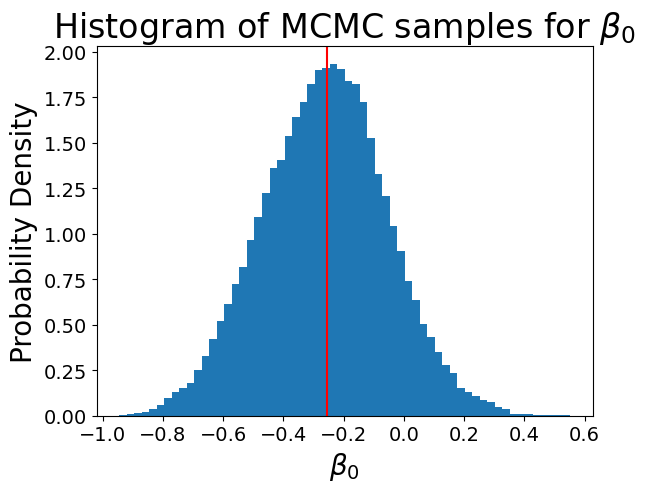

In [20]:
# Plot the histogram of posterior sampled beta_0 parameter
# The red line is the MAP estimate value
hist = plt.hist(beta_chain[:, 0], bins=60, density=True)
plt.axvline(x = map_estimate['x'][0], color = 'r')
plt.title(r'Histogram of MCMC samples for $\beta_{0}$', fontsize=24)
plt.xlabel(r'$\beta_{0}$', fontsize=20)
plt.ylabel('Probability Density', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

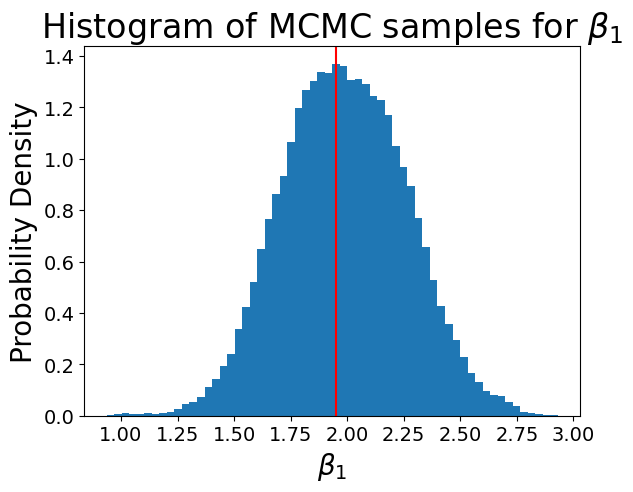

In [21]:
# Plot the histogram of posterior sampled beta_1 parameter
# The red line is the MAP estimate value
hist = plt.hist(beta_chain[:, 1], bins=60, density=True)
plt.axvline(x = map_estimate['x'][1], color = 'r')
plt.title(r'Histogram of MCMC samples for $\beta_{1}$', fontsize=24)
plt.xlabel(r'$\beta_{1}$', fontsize=20)
plt.ylabel('Probability Density', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()